In [1]:
import tensorflow as tf
import numpy as np
import os
import PIL
import pathlib
import matplotlib.pyplot as plt

from PIL import Image
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
data_dir = pathlib.Path('Garbage classification/Garbage classification')
data_jpg = data_dir.glob('*/*.jpg')
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

1933


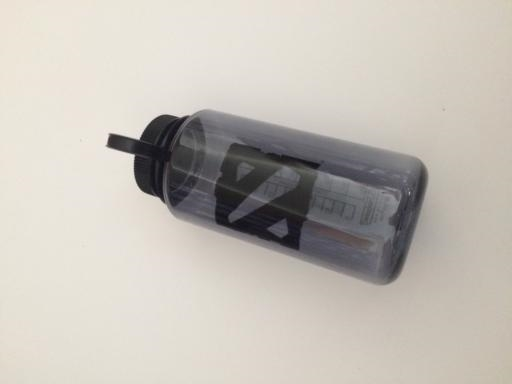

In [3]:
cardboard = list(data_dir.glob("plastic/*.jpg"))
PIL.Image.open(str(cardboard[0]))

In [4]:
#학습데이터
train = tf.keras.preprocessing.image_dataset_from_directory(data_dir,validation_split=0.2,subset="training",seed=123,
                                                            image_size=(120, 120))
validation = tf.keras.preprocessing.image_dataset_from_directory(data_dir,validation_split=0.2,subset="validation",seed=123,
                                                            image_size=(120, 120))

Found 1933 files belonging to 5 classes.
Using 1547 files for training.
Found 1933 files belonging to 5 classes.
Using 386 files for validation.


In [5]:
#클래스명 확인
class_names = train.class_names
print(class_names)

['cardboard', 'glass', 'metal', 'plastic', 'trash']


In [6]:
#shape 확인
for image_batch, labels_batch in train:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 120, 120, 3)
(32,)


In [7]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train = train.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
validation = validation.cache().prefetch(buffer_size=AUTOTUNE)

In [8]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

In [9]:
#Conv 모델 작성
num_classes = len(class_names)

print('클래스 ', num_classes , '개')

model = Sequential()
model.add(layers.experimental.preprocessing.Rescaling(1./255, input_shape=(120, 120, 3)))
model.add(layers.Conv2D(16, 11, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(32, 5, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.Conv2D(64, 3, activation='relu'))
model.add(layers.MaxPooling2D())
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(num_classes))

클래스  5 개


In [10]:
#컴파일
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [11]:
#모델 summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 120, 120, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 110, 110, 16)      5824      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 55, 55, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 51, 51, 32)        12832     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 21, 21, 64)        3

In [12]:
learning = model.fit(train, validation_data=validation,epochs=16)

Epoch 1/16
49/49 [==============================] - 16s 309ms/step - loss: 1.5622 - accuracy: 0.2359 - val_loss: 1.5232 - val_accuracy: 0.2927
Epoch 2/16
49/49 [==============================] - 15s 304ms/step - loss: 1.4577 - accuracy: 0.3374 - val_loss: 1.3654 - val_accuracy: 0.3834
Epoch 3/16
49/49 [==============================] - 15s 306ms/step - loss: 1.3450 - accuracy: 0.4221 - val_loss: 1.3697 - val_accuracy: 0.3964
Epoch 4/16
49/49 [==============================] - 15s 311ms/step - loss: 1.3137 - accuracy: 0.4525 - val_loss: 1.3339 - val_accuracy: 0.3964
Epoch 5/16
49/49 [==============================] - 15s 305ms/step - loss: 1.2184 - accuracy: 0.4732 - val_loss: 1.2748 - val_accuracy: 0.4378
Epoch 6/16
49/49 [==============================] - 15s 307ms/step - loss: 1.1426 - accuracy: 0.5378 - val_loss: 1.2508 - val_accuracy: 0.4767
Epoch 7/16
49/49 [==============================] - 15s 304ms/step - loss: 1.1161 - accuracy: 0.5617 - val_loss: 1.2995 - val_accuracy: 0.4508

Text(0.5, 1.0, '정확도')

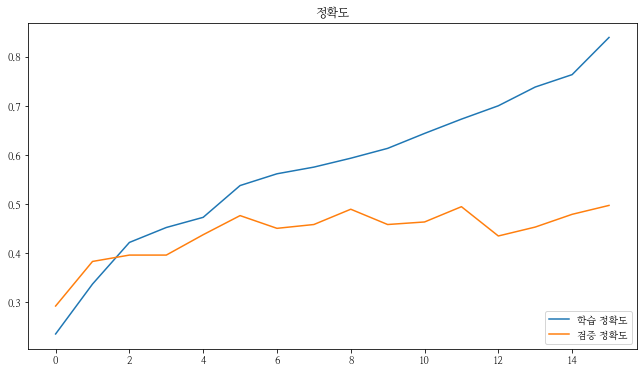

In [13]:
acc = learning.history['accuracy']
val_acc = learning.history['val_accuracy']

epochs_range = range(16)

plt.figure(figsize=(24, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='학습 정확도')
plt.plot(epochs_range, val_acc, label='검증 정확도')
plt.legend(loc='lower right')
plt.title('정확도')

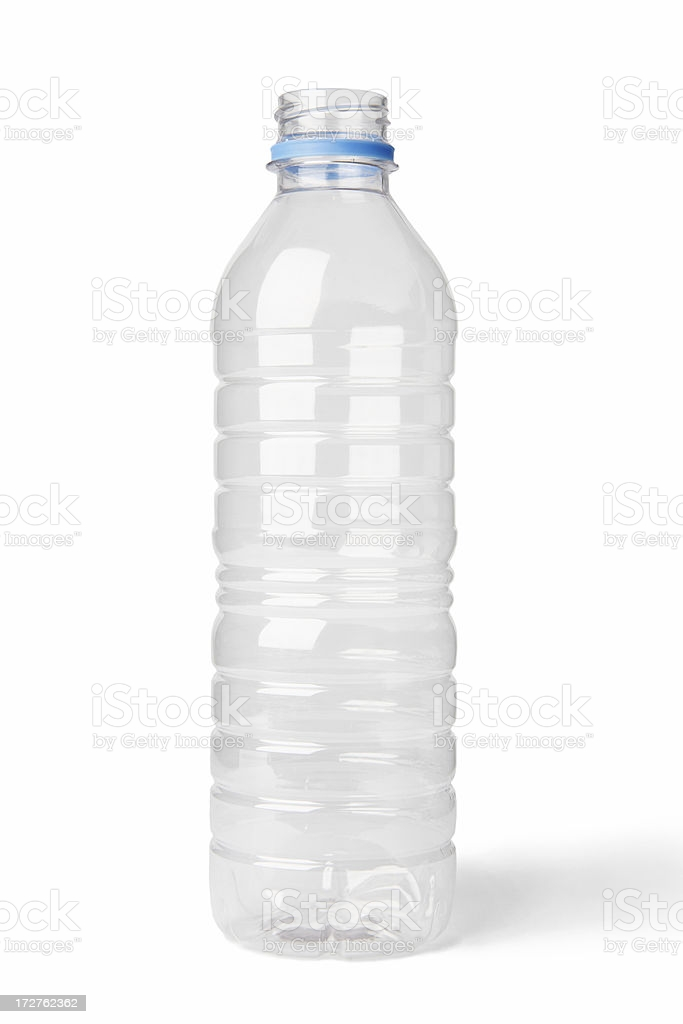

In [14]:
test_img=pathlib.Path('1.jpg')
PIL.Image.open(test_img)

In [15]:
img = keras.preprocessing.image.load_img(
    test_img, target_size=(120, 120)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "이 이미지는 {} (으)로 예측된다. 예상 정확도 : {:.2f} %."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

이 이미지는 plastic (으)로 예측된다. 예상 정확도 : 85.14 %.
